In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])
plt.rcParams["figure.figsize"] = (8, 4)

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dataset 

In [2]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#[S, P] = np.load()
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))


#ind = int(0.8 * len(index))
ind = 0

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])
#molecules = ([], molecules)

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test = S.reshape(-1, dim, dim)
#p_test = S.reshape(-1, dim, dim)

In [3]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    #train=(None, None),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

# Utilities 

In [4]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd(p_guess, p_conv))
    return np.array(p_embedded)


In [5]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

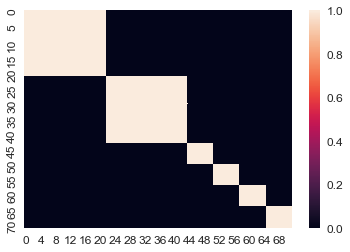

In [6]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [7]:
np.mean(np.abs(p_test.flatten() - embedd_batch(p_test).flatten()))

0.0

# GWH 

In [8]:
from pyscf.scf import hf

p_gwh = np.array([ 
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [9]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities, mf_initializer

print(make_results_str(measure_all_quantities(
    p_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-02 22:54:53: Iteration calculation: 0
[ ] 2019-01-02 22:54:54: Iteration calculation: 1
[ ] 2019-01-02 22:54:56: Iteration calculation: 2
[ ] 2019-01-02 22:54:57: Iteration calculation: 3
[ ] 2019-01-02 22:54:59: Iteration calculation: 4
[ ] 2019-01-02 22:55:00: Iteration calculation: 5
[ ] 2019-01-02 22:55:01: Iteration calculation: 6
[ ] 2019-01-02 22:55:03: Iteration calculation: 7
[ ] 2019-01-02 22:55:05: Iteration calculation: 8
[ ] 2019-01-02 22:55:06: Iteration calculation: 9
[ ] 2019-01-02 22:55:07: Iteration calculation: 10
[ ] 2019-01-02 22:55:08: Iteration calculation: 11
[ ] 2019-01-02 22:55:10: Iteration calculation: 12
[ ] 2019-01-02 22:55:12: Iteration calculation: 13
[ ] 2019-01-02 22:55:13: Iteration calculation: 14
[ ] 2019-01-02 22:55:15: Iteration calculation: 15
[ ] 2019-01-02 22:55:16: Iteration calculation: 16
[ ] 2019-01-02 22:55:17: Iteration calculation: 17
[ ] 2019-01-02 22:55:19: Iteration calculation: 18
[ ] 2019-01-02 22:55:20: Iteration calcul

[ ] 2019-01-02 22:58:39: Iteration calculation: 160
[ ] 2019-01-02 22:58:41: Iteration calculation: 161
[ ] 2019-01-02 22:58:42: Iteration calculation: 162
[ ] 2019-01-02 22:58:43: Iteration calculation: 163
[ ] 2019-01-02 22:58:43: Iteration calculation: 164
[ ] 2019-01-02 22:58:44: Iteration calculation: 165
[ ] 2019-01-02 22:58:46: Iteration calculation: 166
[ ] 2019-01-02 22:58:46: Iteration calculation: 167
[ ] 2019-01-02 22:58:48: Iteration calculation: 168
[ ] 2019-01-02 22:58:49: Iteration calculation: 169
[ ] 2019-01-02 22:58:51: Iteration calculation: 170
[ ] 2019-01-02 22:58:52: Iteration calculation: 171
[ ] 2019-01-02 22:58:53: Iteration calculation: 172
[ ] 2019-01-02 22:58:55: Iteration calculation: 173
[ ] 2019-01-02 22:58:56: Iteration calculation: 174
[ ] 2019-01-02 22:58:58: Iteration calculation: 175
[ ] 2019-01-02 22:58:59: Iteration calculation: 176
[ ] 2019-01-02 22:59:01: Iteration calculation: 177
[ ] 2019-01-02 22:59:02: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-02 23:02:21: Iteration calculation: 318
[ ] 2019-01-02 23:02:21: Iteration calculation: 319
[ ] 2019-01-02 23:02:23: Iteration calculation: 320
[ ] 2019-01-02 23:02:24: Iteration calculation: 321
[ ] 2019-01-02 23:02:26: Iteration calculation: 322
[ ] 2019-01-02 23:02:28: Iteration calculation: 323
[ ] 2019-01-02 23:02:29: Iteration calculation: 324
[ ] 2019-01-02 23:02:31: Iteration calculation: 325
[ ] 2019-01-02 23:02:32: Iteration calculation: 326
[ ] 2019-01-02 23:02:34: Iteration calculation: 327
[ ] 2019-01-02 23:02:35: Iteration calculation: 328
[ ] 2019-01-02 23:02:36: Iteration calculation: 329
[ ] 2019-01-02 23:02:38: Iteration calculation: 330
[ ] 2019-01-02 23:02:39: Iteration calculation: 331
[ ] 2019-01-02 23:02:40: Iteration calculation: 332
[ ] 2019-01-02 23:02:41: Iteration calculation: 333
[ ] 2019-01-02 23:02:43: Iteration calculation: 334
[ ] 2019-01-02 23:02:43: Iteration calculation: 335
[ ] 2019-01-02 23:02:44: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-02 23:06:01: Iteration calculation: 476
[ ] 2019-01-02 23:06:02: Iteration calculation: 477
[ ] 2019-01-02 23:06:04: Iteration calculation: 478
[ ] 2019-01-02 23:06:05: Iteration calculation: 479
[ ] 2019-01-02 23:06:06: Iteration calculation: 480
[ ] 2019-01-02 23:06:07: Iteration calculation: 481
[ ] 2019-01-02 23:06:08: Iteration calculation: 482
[ ] 2019-01-02 23:06:09: Iteration calculation: 483
[ ] 2019-01-02 23:06:09: Iteration calculation: 484
[ ] 2019-01-02 23:06:11: Iteration calculation: 485
[ ] 2019-01-02 23:06:12: Iteration calculation: 486
[ ] 2019-01-02 23:06:14: Iteration calculation: 487
[ ] 2019-01-02 23:06:15: Iteration calculation: 488
[ ] 2019-01-02 23:06:16: Iteration calculation: 489
[ ] 2019-01-02 23:06:18: Iteration calculation: 490
[ ] 2019-01-02 23:06:19: Iteration calculation: 491
[ ] 2019-01-02 23:06:21: Iteration calculation: 492
[ ] 2019-01-02 23:06:21: Iteration calculation: 493
[ ] 2019-01-02 23:06:23: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-02 23:09:33: Iteration calculation: 634
[ ] 2019-01-02 23:09:34: Iteration calculation: 635
[ ] 2019-01-02 23:09:35: Iteration calculation: 636
[ ] 2019-01-02 23:09:37: Iteration calculation: 637
[ ] 2019-01-02 23:09:38: Iteration calculation: 638
[ ] 2019-01-02 23:09:40: Iteration calculation: 639
[ ] 2019-01-02 23:09:41: Iteration calculation: 640
[ ] 2019-01-02 23:09:44: Iteration calculation: 641
[ ] 2019-01-02 23:09:44: Iteration calculation: 642
[ ] 2019-01-02 23:09:46: Iteration calculation: 643
[ ] 2019-01-02 23:09:48: Iteration calculation: 644
[ ] 2019-01-02 23:09:49: Iteration calculation: 645
[ ] 2019-01-02 23:09:51: Iteration calculation: 646
[ ] 2019-01-02 23:09:52: Iteration calculation: 647
[ ] 2019-01-02 23:09:54: Iteration calculation: 648
[ ] 2019-01-02 23:09:55: Iteration calculation: 649
[ ] 2019-01-02 23:09:56: Iteration calculation: 650
[ ] 2019-01-02 23:09:58: Iteration calculation: 651
[ ] 2019-01-02 23:09:59: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-02 23:13:22: Iteration calculation: 792
[ ] 2019-01-02 23:13:24: Iteration calculation: 793
[ ] 2019-01-02 23:13:26: Iteration calculation: 794
[ ] 2019-01-02 23:13:27: Iteration calculation: 795
[ ] 2019-01-02 23:13:28: Iteration calculation: 796
[ ] 2019-01-02 23:13:28: Iteration calculation: 797
[ ] 2019-01-02 23:13:30: Iteration calculation: 798
[ ] 2019-01-02 23:13:31: Iteration calculation: 799
[ ] 2019-01-02 23:13:33: Iteration calculation: 800
[ ] 2019-01-02 23:13:34: Iteration calculation: 801
[ ] 2019-01-02 23:13:36: Iteration calculation: 802
[ ] 2019-01-02 23:13:37: Iteration calculation: 803
[ ] 2019-01-02 23:13:39: Iteration calculation: 804
[ ] 2019-01-02 23:13:40: Iteration calculation: 805
[ ] 2019-01-02 23:13:42: Iteration calculation: 806
[ ] 2019-01-02 23:13:43: Iteration calculation: 807
[ ] 2019-01-02 23:13:44: Iteration calculation: 808
[ ] 2019-01-02 23:13:46: Iteration calculation: 809
[ ] 2019-01-02 23:13:47: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-02 23:16:55: Iteration calculation: 950
[ ] 2019-01-02 23:16:56: Iteration calculation: 951
[ ] 2019-01-02 23:16:57: Iteration calculation: 952
[ ] 2019-01-02 23:16:58: Iteration calculation: 953
[ ] 2019-01-02 23:17:00: Iteration calculation: 954
[ ] 2019-01-02 23:17:01: Iteration calculation: 955
[ ] 2019-01-02 23:17:03: Iteration calculation: 956
[ ] 2019-01-02 23:17:04: Iteration calculation: 957
[ ] 2019-01-02 23:17:06: Iteration calculation: 958
[ ] 2019-01-02 23:17:06: Iteration calculation: 959
[ ] 2019-01-02 23:17:08: Iteration calculation: 960
[ ] 2019-01-02 23:17:09: Iteration calculation: 961
[ ] 2019-01-02 23:17:10: Iteration calculation: 962
[ ] 2019-01-02 23:17:11: Iteration calculation: 963
[ ] 2019-01-02 23:17:13: Iteration calculation: 964
[ ] 2019-01-02 23:17:14: Iteration calculation: 965
[ ] 2019-01-02 23:17:16: Iteration calculation: 966
[ ] 2019-01-02 23:17:17: Iteration calculation: 967
[ ] 2019-01-02 23:17:18: Iteration calculation: 968
[ ] 2019-01-

### Damped 

In [10]:
from SCFInitialGuess.utilities.analysis import statistics

In [11]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-02 23:18:04: Iteration calculation: 0
[ ] 2019-01-02 23:18:06: Iteration calculation: 1
[ ] 2019-01-02 23:18:08: Iteration calculation: 2
[ ] 2019-01-02 23:18:10: Iteration calculation: 3
[ ] 2019-01-02 23:18:12: Iteration calculation: 4
[ ] 2019-01-02 23:18:13: Iteration calculation: 5
[ ] 2019-01-02 23:18:15: Iteration calculation: 6
[ ] 2019-01-02 23:18:16: Iteration calculation: 7
[ ] 2019-01-02 23:18:18: Iteration calculation: 8
[ ] 2019-01-02 23:18:20: Iteration calculation: 9
[ ] 2019-01-02 23:18:21: Iteration calculation: 10
[ ] 2019-01-02 23:18:23: Iteration calculation: 11
[ ] 2019-01-02 23:18:24: Iteration calculation: 12
[ ] 2019-01-02 23:18:26: Iteration calculation: 13
[ ] 2019-01-02 23:18:28: Iteration calculation: 14
[ ] 2019-01-02 23:18:29: Iteration calculation: 15
[ ] 2019-01-02 23:18:32: Iteration calculation: 16
[ ] 2019-01-02 23:18:35: Iteration calculation: 17
[ ] 2019-01-02 23:18:37: Iteration calculation: 18
[ ] 2019-01-02 23:18:39: Iteration calcul

[ ] 2019-01-02 23:22:18: Iteration calculation: 160
[ ] 2019-01-02 23:22:20: Iteration calculation: 161
[ ] 2019-01-02 23:22:21: Iteration calculation: 162
[ ] 2019-01-02 23:22:22: Iteration calculation: 163
[ ] 2019-01-02 23:22:24: Iteration calculation: 164
[ ] 2019-01-02 23:22:27: Iteration calculation: 165
[ ] 2019-01-02 23:22:29: Iteration calculation: 166
[ ] 2019-01-02 23:22:29: Iteration calculation: 167
[ ] 2019-01-02 23:22:32: Iteration calculation: 168
[ ] 2019-01-02 23:22:33: Iteration calculation: 169
[ ] 2019-01-02 23:22:36: Iteration calculation: 170
[ ] 2019-01-02 23:22:38: Iteration calculation: 171
[ ] 2019-01-02 23:22:39: Iteration calculation: 172
[ ] 2019-01-02 23:22:41: Iteration calculation: 173
[ ] 2019-01-02 23:22:42: Iteration calculation: 174
[ ] 2019-01-02 23:22:44: Iteration calculation: 175
[ ] 2019-01-02 23:22:44: Iteration calculation: 176
[ ] 2019-01-02 23:22:46: Iteration calculation: 177
[ ] 2019-01-02 23:22:47: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-02 23:26:19: Iteration calculation: 318
[ ] 2019-01-02 23:26:20: Iteration calculation: 319
[ ] 2019-01-02 23:26:21: Iteration calculation: 320
[ ] 2019-01-02 23:26:23: Iteration calculation: 321
[ ] 2019-01-02 23:26:24: Iteration calculation: 322
[ ] 2019-01-02 23:26:26: Iteration calculation: 323
[ ] 2019-01-02 23:26:28: Iteration calculation: 324
[ ] 2019-01-02 23:26:31: Iteration calculation: 325
[ ] 2019-01-02 23:26:32: Iteration calculation: 326
[ ] 2019-01-02 23:26:34: Iteration calculation: 327
[ ] 2019-01-02 23:26:36: Iteration calculation: 328
[ ] 2019-01-02 23:26:37: Iteration calculation: 329
[ ] 2019-01-02 23:26:40: Iteration calculation: 330
[ ] 2019-01-02 23:26:41: Iteration calculation: 331
[ ] 2019-01-02 23:26:43: Iteration calculation: 332
[ ] 2019-01-02 23:26:44: Iteration calculation: 333
[ ] 2019-01-02 23:26:46: Iteration calculation: 334
[ ] 2019-01-02 23:26:47: Iteration calculation: 335
[ ] 2019-01-02 23:26:49: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-02 23:30:32: Iteration calculation: 476
[ ] 2019-01-02 23:30:33: Iteration calculation: 477
[ ] 2019-01-02 23:30:35: Iteration calculation: 478
[ ] 2019-01-02 23:30:38: Iteration calculation: 479
[ ] 2019-01-02 23:30:40: Iteration calculation: 480
[ ] 2019-01-02 23:30:42: Iteration calculation: 481
[ ] 2019-01-02 23:30:43: Iteration calculation: 482
[ ] 2019-01-02 23:30:45: Iteration calculation: 483
[ ] 2019-01-02 23:30:47: Iteration calculation: 484
[ ] 2019-01-02 23:30:49: Iteration calculation: 485
[ ] 2019-01-02 23:30:50: Iteration calculation: 486
[ ] 2019-01-02 23:30:52: Iteration calculation: 487
[ ] 2019-01-02 23:30:53: Iteration calculation: 488
[ ] 2019-01-02 23:30:55: Iteration calculation: 489
[ ] 2019-01-02 23:30:56: Iteration calculation: 490
[ ] 2019-01-02 23:30:59: Iteration calculation: 491
[ ] 2019-01-02 23:31:01: Iteration calculation: 492
[ ] 2019-01-02 23:31:03: Iteration calculation: 493
[ ] 2019-01-02 23:31:05: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-02 23:34:56: Iteration calculation: 634
[ ] 2019-01-02 23:34:57: Iteration calculation: 635
[ ] 2019-01-02 23:34:59: Iteration calculation: 636
[ ] 2019-01-02 23:35:00: Iteration calculation: 637
[ ] 2019-01-02 23:35:02: Iteration calculation: 638
[ ] 2019-01-02 23:35:03: Iteration calculation: 639
[ ] 2019-01-02 23:35:05: Iteration calculation: 640
[ ] 2019-01-02 23:35:06: Iteration calculation: 641
[ ] 2019-01-02 23:35:09: Iteration calculation: 642
[ ] 2019-01-02 23:35:11: Iteration calculation: 643
[ ] 2019-01-02 23:35:13: Iteration calculation: 644
[ ] 2019-01-02 23:35:15: Iteration calculation: 645
[ ] 2019-01-02 23:35:16: Iteration calculation: 646
[ ] 2019-01-02 23:35:18: Iteration calculation: 647
[ ] 2019-01-02 23:35:19: Iteration calculation: 648
[ ] 2019-01-02 23:35:21: Iteration calculation: 649
[ ] 2019-01-02 23:35:22: Iteration calculation: 650
[ ] 2019-01-02 23:35:24: Iteration calculation: 651
[ ] 2019-01-02 23:35:25: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-02 23:39:18: Iteration calculation: 792
[ ] 2019-01-02 23:39:20: Iteration calculation: 793
[ ] 2019-01-02 23:39:22: Iteration calculation: 794
[ ] 2019-01-02 23:39:24: Iteration calculation: 795
[ ] 2019-01-02 23:39:25: Iteration calculation: 796
[ ] 2019-01-02 23:39:27: Iteration calculation: 797
[ ] 2019-01-02 23:39:28: Iteration calculation: 798
[ ] 2019-01-02 23:39:30: Iteration calculation: 799
[ ] 2019-01-02 23:39:31: Iteration calculation: 800
[ ] 2019-01-02 23:39:33: Iteration calculation: 801
[ ] 2019-01-02 23:39:34: Iteration calculation: 802
[ ] 2019-01-02 23:39:36: Iteration calculation: 803
[ ] 2019-01-02 23:39:37: Iteration calculation: 804
[ ] 2019-01-02 23:39:39: Iteration calculation: 805
[ ] 2019-01-02 23:39:40: Iteration calculation: 806
[ ] 2019-01-02 23:39:42: Iteration calculation: 807
[ ] 2019-01-02 23:39:43: Iteration calculation: 808
[ ] 2019-01-02 23:39:45: Iteration calculation: 809
[ ] 2019-01-02 23:39:48: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-02 23:43:46: Iteration calculation: 950
[ ] 2019-01-02 23:43:47: Iteration calculation: 951
[ ] 2019-01-02 23:43:49: Iteration calculation: 952
[ ] 2019-01-02 23:43:50: Iteration calculation: 953
[ ] 2019-01-02 23:43:52: Iteration calculation: 954
[ ] 2019-01-02 23:43:52: Iteration calculation: 955
[ ] 2019-01-02 23:43:54: Iteration calculation: 956
[ ] 2019-01-02 23:43:55: Iteration calculation: 957
[ ] 2019-01-02 23:43:57: Iteration calculation: 958
[ ] 2019-01-02 23:43:58: Iteration calculation: 959
[ ] 2019-01-02 23:44:00: Iteration calculation: 960
[ ] 2019-01-02 23:44:03: Iteration calculation: 961
[ ] 2019-01-02 23:44:05: Iteration calculation: 962
[ ] 2019-01-02 23:44:06: Iteration calculation: 963
[ ] 2019-01-02 23:44:08: Iteration calculation: 964
[ ] 2019-01-02 23:44:09: Iteration calculation: 965
[ ] 2019-01-02 23:44:11: Iteration calculation: 966
[ ] 2019-01-02 23:44:13: Iteration calculation: 967
[ ] 2019-01-02 23:44:14: Iteration calculation: 968
[ ] 2019-01-

In [1]:
967/1001

0.9660339660339661

### DIIS 

In [12]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-02 23:45:11: Iteration calculation: 0
[ ] 2019-01-02 23:45:11: Iteration calculation: 1
[ ] 2019-01-02 23:45:12: Iteration calculation: 2
[ ] 2019-01-02 23:45:13: Iteration calculation: 3
[ ] 2019-01-02 23:45:13: Iteration calculation: 4
[ ] 2019-01-02 23:45:14: Iteration calculation: 5
[ ] 2019-01-02 23:45:15: Iteration calculation: 6
[ ] 2019-01-02 23:45:15: Iteration calculation: 7
[ ] 2019-01-02 23:45:16: Iteration calculation: 8
[ ] 2019-01-02 23:45:16: Iteration calculation: 9
[ ] 2019-01-02 23:45:17: Iteration calculation: 10
[ ] 2019-01-02 23:45:17: Iteration calculation: 11
[ ] 2019-01-02 23:45:18: Iteration calculation: 12
[ ] 2019-01-02 23:45:18: Iteration calculation: 13
[ ] 2019-01-02 23:45:19: Iteration calculation: 14
[ ] 2019-01-02 23:45:19: Iteration calculation: 15
[ ] 2019-01-02 23:45:20: Iteration calculation: 16
[ ] 2019-01-02 23:45:20: Iteration calculation: 17
[ ] 2019-01-02 23:45:20: Iteration calculation: 18
[ ] 2019-01-02 23:45:21: Iteration calcul

[ ] 2019-01-02 23:46:26: Iteration calculation: 160
[ ] 2019-01-02 23:46:27: Iteration calculation: 161
[ ] 2019-01-02 23:46:27: Iteration calculation: 162
[ ] 2019-01-02 23:46:28: Iteration calculation: 163
[ ] 2019-01-02 23:46:28: Iteration calculation: 164
[ ] 2019-01-02 23:46:28: Iteration calculation: 165
[ ] 2019-01-02 23:46:29: Iteration calculation: 166
[ ] 2019-01-02 23:46:29: Iteration calculation: 167
[ ] 2019-01-02 23:46:30: Iteration calculation: 168
[ ] 2019-01-02 23:46:30: Iteration calculation: 169
[ ] 2019-01-02 23:46:30: Iteration calculation: 170
[ ] 2019-01-02 23:46:31: Iteration calculation: 171
[ ] 2019-01-02 23:46:31: Iteration calculation: 172
[ ] 2019-01-02 23:46:32: Iteration calculation: 173
[ ] 2019-01-02 23:46:32: Iteration calculation: 174
[ ] 2019-01-02 23:46:33: Iteration calculation: 175
[ ] 2019-01-02 23:46:33: Iteration calculation: 176
[ ] 2019-01-02 23:46:34: Iteration calculation: 177
[ ] 2019-01-02 23:46:34: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-02 23:47:39: Iteration calculation: 318
[ ] 2019-01-02 23:47:39: Iteration calculation: 319
[ ] 2019-01-02 23:47:40: Iteration calculation: 320
[ ] 2019-01-02 23:47:40: Iteration calculation: 321
[ ] 2019-01-02 23:47:41: Iteration calculation: 322
[ ] 2019-01-02 23:47:41: Iteration calculation: 323
[ ] 2019-01-02 23:47:42: Iteration calculation: 324
[ ] 2019-01-02 23:47:42: Iteration calculation: 325
[ ] 2019-01-02 23:47:43: Iteration calculation: 326
[ ] 2019-01-02 23:47:43: Iteration calculation: 327
[ ] 2019-01-02 23:47:44: Iteration calculation: 328
[ ] 2019-01-02 23:47:44: Iteration calculation: 329
[ ] 2019-01-02 23:47:45: Iteration calculation: 330
[ ] 2019-01-02 23:47:45: Iteration calculation: 331
[ ] 2019-01-02 23:47:46: Iteration calculation: 332
[ ] 2019-01-02 23:47:46: Iteration calculation: 333
[ ] 2019-01-02 23:47:46: Iteration calculation: 334
[ ] 2019-01-02 23:47:47: Iteration calculation: 335
[ ] 2019-01-02 23:47:47: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-02 23:48:52: Iteration calculation: 476
[ ] 2019-01-02 23:48:52: Iteration calculation: 477
[ ] 2019-01-02 23:48:53: Iteration calculation: 478
[ ] 2019-01-02 23:48:53: Iteration calculation: 479
[ ] 2019-01-02 23:48:54: Iteration calculation: 480
[ ] 2019-01-02 23:48:54: Iteration calculation: 481
[ ] 2019-01-02 23:48:55: Iteration calculation: 482
[ ] 2019-01-02 23:48:55: Iteration calculation: 483
[ ] 2019-01-02 23:48:56: Iteration calculation: 484
[ ] 2019-01-02 23:48:56: Iteration calculation: 485
[ ] 2019-01-02 23:48:57: Iteration calculation: 486
[ ] 2019-01-02 23:48:57: Iteration calculation: 487
[ ] 2019-01-02 23:48:57: Iteration calculation: 488
[ ] 2019-01-02 23:48:58: Iteration calculation: 489
[ ] 2019-01-02 23:48:58: Iteration calculation: 490
[ ] 2019-01-02 23:48:59: Iteration calculation: 491
[ ] 2019-01-02 23:48:59: Iteration calculation: 492
[ ] 2019-01-02 23:49:00: Iteration calculation: 493
[ ] 2019-01-02 23:49:00: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-02 23:50:05: Iteration calculation: 634
[ ] 2019-01-02 23:50:06: Iteration calculation: 635
[ ] 2019-01-02 23:50:06: Iteration calculation: 636
[ ] 2019-01-02 23:50:06: Iteration calculation: 637
[ ] 2019-01-02 23:50:07: Iteration calculation: 638
[ ] 2019-01-02 23:50:07: Iteration calculation: 639
[ ] 2019-01-02 23:50:08: Iteration calculation: 640
[ ] 2019-01-02 23:50:08: Iteration calculation: 641
[ ] 2019-01-02 23:50:09: Iteration calculation: 642
[ ] 2019-01-02 23:50:09: Iteration calculation: 643
[ ] 2019-01-02 23:50:10: Iteration calculation: 644
[ ] 2019-01-02 23:50:10: Iteration calculation: 645
[ ] 2019-01-02 23:50:10: Iteration calculation: 646
[ ] 2019-01-02 23:50:11: Iteration calculation: 647
[ ] 2019-01-02 23:50:12: Iteration calculation: 648
[ ] 2019-01-02 23:50:12: Iteration calculation: 649
[ ] 2019-01-02 23:50:12: Iteration calculation: 650
[ ] 2019-01-02 23:50:13: Iteration calculation: 651
[ ] 2019-01-02 23:50:13: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-02 23:51:16: Iteration calculation: 792
[ ] 2019-01-02 23:51:16: Iteration calculation: 793
[ ] 2019-01-02 23:51:17: Iteration calculation: 794
[ ] 2019-01-02 23:51:17: Iteration calculation: 795
[ ] 2019-01-02 23:51:18: Iteration calculation: 796
[ ] 2019-01-02 23:51:18: Iteration calculation: 797
[ ] 2019-01-02 23:51:19: Iteration calculation: 798
[ ] 2019-01-02 23:51:19: Iteration calculation: 799
[ ] 2019-01-02 23:51:19: Iteration calculation: 800
[ ] 2019-01-02 23:51:20: Iteration calculation: 801
[ ] 2019-01-02 23:51:20: Iteration calculation: 802
[ ] 2019-01-02 23:51:21: Iteration calculation: 803
[ ] 2019-01-02 23:51:21: Iteration calculation: 804
[ ] 2019-01-02 23:51:22: Iteration calculation: 805
[ ] 2019-01-02 23:51:22: Iteration calculation: 806
[ ] 2019-01-02 23:51:23: Iteration calculation: 807
[ ] 2019-01-02 23:51:23: Iteration calculation: 808
[ ] 2019-01-02 23:51:24: Iteration calculation: 809
[ ] 2019-01-02 23:51:24: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-02 23:52:31: Iteration calculation: 950
[ ] 2019-01-02 23:52:32: Iteration calculation: 951
[ ] 2019-01-02 23:52:32: Iteration calculation: 952
[ ] 2019-01-02 23:52:32: Iteration calculation: 953
[ ] 2019-01-02 23:52:33: Iteration calculation: 954
[ ] 2019-01-02 23:52:33: Iteration calculation: 955
[ ] 2019-01-02 23:52:34: Iteration calculation: 956
[ ] 2019-01-02 23:52:34: Iteration calculation: 957
[ ] 2019-01-02 23:52:35: Iteration calculation: 958
[ ] 2019-01-02 23:52:36: Iteration calculation: 959
[ ] 2019-01-02 23:52:36: Iteration calculation: 960
[ ] 2019-01-02 23:52:36: Iteration calculation: 961
[ ] 2019-01-02 23:52:37: Iteration calculation: 962
[ ] 2019-01-02 23:52:37: Iteration calculation: 963
[ ] 2019-01-02 23:52:38: Iteration calculation: 964
[ ] 2019-01-02 23:52:38: Iteration calculation: 965
[ ] 2019-01-02 23:52:39: Iteration calculation: 966
[ ] 2019-01-02 23:52:39: Iteration calculation: 967
[ ] 2019-01-02 23:52:40: Iteration calculation: 968
[ ] 2019-01-

# Embedded GWH 

In [13]:
p_embedded_gwh = embedd_batch(p_gwh)

In [17]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-03 09:25:53: Iteration calculation: 0
[ ] 2019-01-03 09:25:54: Iteration calculation: 1
[ ] 2019-01-03 09:25:55: Iteration calculation: 2
[ ] 2019-01-03 09:25:56: Iteration calculation: 3
[ ] 2019-01-03 09:25:57: Iteration calculation: 4
[ ] 2019-01-03 09:25:58: Iteration calculation: 5
[ ] 2019-01-03 09:25:59: Iteration calculation: 6
[ ] 2019-01-03 09:26:00: Iteration calculation: 7
[ ] 2019-01-03 09:26:01: Iteration calculation: 8
[ ] 2019-01-03 09:26:02: Iteration calculation: 9
[ ] 2019-01-03 09:26:03: Iteration calculation: 10
[ ] 2019-01-03 09:26:03: Iteration calculation: 11
[ ] 2019-01-03 09:26:04: Iteration calculation: 12
[ ] 2019-01-03 09:26:04: Iteration calculation: 13
[ ] 2019-01-03 09:26:05: Iteration calculation: 14
[ ] 2019-01-03 09:26:05: Iteration calculation: 15
[ ] 2019-01-03 09:26:06: Iteration calculation: 16
[ ] 2019-01-03 09:26:06: Iteration calculation: 17
[ ] 2019-01-03 09:26:07: Iteration calculation: 18
[ ] 2019-01-03 09:26:08: Iteration calcul

[ ] 2019-01-03 09:27:36: Iteration calculation: 160
[ ] 2019-01-03 09:27:37: Iteration calculation: 161
[ ] 2019-01-03 09:27:37: Iteration calculation: 162
[ ] 2019-01-03 09:27:38: Iteration calculation: 163
[ ] 2019-01-03 09:27:38: Iteration calculation: 164
[ ] 2019-01-03 09:27:39: Iteration calculation: 165
[ ] 2019-01-03 09:27:39: Iteration calculation: 166
[ ] 2019-01-03 09:27:40: Iteration calculation: 167
[ ] 2019-01-03 09:27:40: Iteration calculation: 168
[ ] 2019-01-03 09:27:41: Iteration calculation: 169
[ ] 2019-01-03 09:27:42: Iteration calculation: 170
[ ] 2019-01-03 09:27:42: Iteration calculation: 171
[ ] 2019-01-03 09:27:43: Iteration calculation: 172
[ ] 2019-01-03 09:27:43: Iteration calculation: 173
[ ] 2019-01-03 09:27:43: Iteration calculation: 174
[ ] 2019-01-03 09:27:45: Iteration calculation: 175
[ ] 2019-01-03 09:27:45: Iteration calculation: 176
[ ] 2019-01-03 09:27:45: Iteration calculation: 177
[ ] 2019-01-03 09:27:46: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 09:29:16: Iteration calculation: 318
[ ] 2019-01-03 09:29:17: Iteration calculation: 319
[ ] 2019-01-03 09:29:17: Iteration calculation: 320
[ ] 2019-01-03 09:29:18: Iteration calculation: 321
[ ] 2019-01-03 09:29:18: Iteration calculation: 322
[ ] 2019-01-03 09:29:19: Iteration calculation: 323
[ ] 2019-01-03 09:29:19: Iteration calculation: 324
[ ] 2019-01-03 09:29:20: Iteration calculation: 325
[ ] 2019-01-03 09:29:20: Iteration calculation: 326
[ ] 2019-01-03 09:29:21: Iteration calculation: 327
[ ] 2019-01-03 09:29:21: Iteration calculation: 328
[ ] 2019-01-03 09:29:22: Iteration calculation: 329
[ ] 2019-01-03 09:29:22: Iteration calculation: 330
[ ] 2019-01-03 09:29:23: Iteration calculation: 331
[ ] 2019-01-03 09:29:24: Iteration calculation: 332
[ ] 2019-01-03 09:29:24: Iteration calculation: 333
[ ] 2019-01-03 09:29:25: Iteration calculation: 334
[ ] 2019-01-03 09:29:25: Iteration calculation: 335
[ ] 2019-01-03 09:29:26: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 09:31:04: Iteration calculation: 476
[ ] 2019-01-03 09:31:05: Iteration calculation: 477
[ ] 2019-01-03 09:31:05: Iteration calculation: 478
[ ] 2019-01-03 09:31:06: Iteration calculation: 479
[ ] 2019-01-03 09:31:06: Iteration calculation: 480
[ ] 2019-01-03 09:31:07: Iteration calculation: 481
[ ] 2019-01-03 09:31:08: Iteration calculation: 482
[ ] 2019-01-03 09:31:08: Iteration calculation: 483
[ ] 2019-01-03 09:31:09: Iteration calculation: 484
[ ] 2019-01-03 09:31:09: Iteration calculation: 485
[ ] 2019-01-03 09:31:09: Iteration calculation: 486
[ ] 2019-01-03 09:31:10: Iteration calculation: 487
[ ] 2019-01-03 09:31:10: Iteration calculation: 488
[ ] 2019-01-03 09:31:11: Iteration calculation: 489
[ ] 2019-01-03 09:31:11: Iteration calculation: 490
[ ] 2019-01-03 09:31:13: Iteration calculation: 491
[ ] 2019-01-03 09:31:14: Iteration calculation: 492
[ ] 2019-01-03 09:31:15: Iteration calculation: 493
[ ] 2019-01-03 09:31:16: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 09:32:47: Iteration calculation: 634
[ ] 2019-01-03 09:32:48: Iteration calculation: 635
[ ] 2019-01-03 09:32:48: Iteration calculation: 636
[ ] 2019-01-03 09:32:49: Iteration calculation: 637
[ ] 2019-01-03 09:32:50: Iteration calculation: 638
[ ] 2019-01-03 09:32:50: Iteration calculation: 639
[ ] 2019-01-03 09:32:51: Iteration calculation: 640
[ ] 2019-01-03 09:32:52: Iteration calculation: 641
[ ] 2019-01-03 09:32:53: Iteration calculation: 642
[ ] 2019-01-03 09:32:53: Iteration calculation: 643
[ ] 2019-01-03 09:32:54: Iteration calculation: 644
[ ] 2019-01-03 09:32:55: Iteration calculation: 645
[ ] 2019-01-03 09:32:55: Iteration calculation: 646
[ ] 2019-01-03 09:32:56: Iteration calculation: 647
[ ] 2019-01-03 09:32:57: Iteration calculation: 648
[ ] 2019-01-03 09:32:57: Iteration calculation: 649
[ ] 2019-01-03 09:32:59: Iteration calculation: 650
[ ] 2019-01-03 09:33:00: Iteration calculation: 651
[ ] 2019-01-03 09:33:00: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 09:34:42: Iteration calculation: 792
[ ] 2019-01-03 09:34:43: Iteration calculation: 793
[ ] 2019-01-03 09:34:44: Iteration calculation: 794
[ ] 2019-01-03 09:34:44: Iteration calculation: 795
[ ] 2019-01-03 09:34:44: Iteration calculation: 796
[ ] 2019-01-03 09:34:45: Iteration calculation: 797
[ ] 2019-01-03 09:34:46: Iteration calculation: 798
[ ] 2019-01-03 09:34:46: Iteration calculation: 799
[ ] 2019-01-03 09:34:47: Iteration calculation: 800
[ ] 2019-01-03 09:34:48: Iteration calculation: 801
[ ] 2019-01-03 09:34:48: Iteration calculation: 802
[ ] 2019-01-03 09:34:49: Iteration calculation: 803
[ ] 2019-01-03 09:34:50: Iteration calculation: 804
[ ] 2019-01-03 09:34:51: Iteration calculation: 805
[ ] 2019-01-03 09:34:52: Iteration calculation: 806
[ ] 2019-01-03 09:34:52: Iteration calculation: 807
[ ] 2019-01-03 09:34:53: Iteration calculation: 808
[ ] 2019-01-03 09:34:53: Iteration calculation: 809
[ ] 2019-01-03 09:34:54: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 09:36:22: Iteration calculation: 950
[ ] 2019-01-03 09:36:23: Iteration calculation: 951
[ ] 2019-01-03 09:36:24: Iteration calculation: 952
[ ] 2019-01-03 09:36:24: Iteration calculation: 953
[ ] 2019-01-03 09:36:25: Iteration calculation: 954
[ ] 2019-01-03 09:36:25: Iteration calculation: 955
[ ] 2019-01-03 09:36:27: Iteration calculation: 956
[ ] 2019-01-03 09:36:27: Iteration calculation: 957
[ ] 2019-01-03 09:36:28: Iteration calculation: 958
[ ] 2019-01-03 09:36:28: Iteration calculation: 959
[ ] 2019-01-03 09:36:29: Iteration calculation: 960
[ ] 2019-01-03 09:36:30: Iteration calculation: 961
[ ] 2019-01-03 09:36:30: Iteration calculation: 962
[ ] 2019-01-03 09:36:31: Iteration calculation: 963
[ ] 2019-01-03 09:36:32: Iteration calculation: 964
[ ] 2019-01-03 09:36:33: Iteration calculation: 965
[ ] 2019-01-03 09:36:34: Iteration calculation: 966
[ ] 2019-01-03 09:36:34: Iteration calculation: 967
[ ] 2019-01-03 09:36:35: Iteration calculation: 968
[ ] 2019-01-

In [2]:
51/1001

0.05094905094905095

### Damped 

In [15]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_embedded_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-03 00:27:12: Iteration calculation: 0
[ ] 2019-01-03 00:27:12: Iteration calculation: 1
[ ] 2019-01-03 00:27:13: Iteration calculation: 2
[ ] 2019-01-03 00:27:13: Iteration calculation: 3
[ ] 2019-01-03 00:27:14: Iteration calculation: 4
[ ] 2019-01-03 00:27:15: Iteration calculation: 5
[ ] 2019-01-03 00:27:15: Iteration calculation: 6
[ ] 2019-01-03 00:27:16: Iteration calculation: 7
[ ] 2019-01-03 00:27:17: Iteration calculation: 8
[ ] 2019-01-03 00:27:17: Iteration calculation: 9
[ ] 2019-01-03 00:27:18: Iteration calculation: 10
[ ] 2019-01-03 00:27:19: Iteration calculation: 11
[ ] 2019-01-03 00:27:19: Iteration calculation: 12
[ ] 2019-01-03 00:27:20: Iteration calculation: 13
[ ] 2019-01-03 00:27:20: Iteration calculation: 14
[ ] 2019-01-03 00:27:21: Iteration calculation: 15
[ ] 2019-01-03 00:27:21: Iteration calculation: 16
[ ] 2019-01-03 00:27:22: Iteration calculation: 17
[ ] 2019-01-03 00:27:23: Iteration calculation: 18
[ ] 2019-01-03 00:27:23: Iteration calcul

[ ] 2019-01-03 00:29:00: Iteration calculation: 160
[ ] 2019-01-03 00:29:00: Iteration calculation: 161
[ ] 2019-01-03 00:29:01: Iteration calculation: 162
[ ] 2019-01-03 00:29:02: Iteration calculation: 163
[ ] 2019-01-03 00:29:02: Iteration calculation: 164
[ ] 2019-01-03 00:29:03: Iteration calculation: 165
[ ] 2019-01-03 00:29:03: Iteration calculation: 166
[ ] 2019-01-03 00:29:04: Iteration calculation: 167
[ ] 2019-01-03 00:29:04: Iteration calculation: 168
[ ] 2019-01-03 00:29:05: Iteration calculation: 169
[ ] 2019-01-03 00:29:06: Iteration calculation: 170
[ ] 2019-01-03 00:29:06: Iteration calculation: 171
[ ] 2019-01-03 00:29:07: Iteration calculation: 172
[ ] 2019-01-03 00:29:07: Iteration calculation: 173
[ ] 2019-01-03 00:29:08: Iteration calculation: 174
[ ] 2019-01-03 00:29:09: Iteration calculation: 175
[ ] 2019-01-03 00:29:10: Iteration calculation: 176
[ ] 2019-01-03 00:29:10: Iteration calculation: 177
[ ] 2019-01-03 00:29:11: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 00:30:41: Iteration calculation: 318
[ ] 2019-01-03 00:30:41: Iteration calculation: 319
[ ] 2019-01-03 00:30:42: Iteration calculation: 320
[ ] 2019-01-03 00:30:42: Iteration calculation: 321
[ ] 2019-01-03 00:30:43: Iteration calculation: 322
[ ] 2019-01-03 00:30:44: Iteration calculation: 323
[ ] 2019-01-03 00:30:44: Iteration calculation: 324
[ ] 2019-01-03 00:30:45: Iteration calculation: 325
[ ] 2019-01-03 00:30:46: Iteration calculation: 326
[ ] 2019-01-03 00:30:47: Iteration calculation: 327
[ ] 2019-01-03 00:30:47: Iteration calculation: 328
[ ] 2019-01-03 00:30:48: Iteration calculation: 329
[ ] 2019-01-03 00:30:49: Iteration calculation: 330
[ ] 2019-01-03 00:30:49: Iteration calculation: 331
[ ] 2019-01-03 00:30:50: Iteration calculation: 332
[ ] 2019-01-03 00:30:50: Iteration calculation: 333
[ ] 2019-01-03 00:30:51: Iteration calculation: 334
[ ] 2019-01-03 00:30:51: Iteration calculation: 335
[ ] 2019-01-03 00:30:52: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 00:32:17: Iteration calculation: 476
[ ] 2019-01-03 00:32:18: Iteration calculation: 477
[ ] 2019-01-03 00:32:18: Iteration calculation: 478
[ ] 2019-01-03 00:32:19: Iteration calculation: 479
[ ] 2019-01-03 00:32:19: Iteration calculation: 480
[ ] 2019-01-03 00:32:20: Iteration calculation: 481
[ ] 2019-01-03 00:32:20: Iteration calculation: 482
[ ] 2019-01-03 00:32:21: Iteration calculation: 483
[ ] 2019-01-03 00:32:22: Iteration calculation: 484
[ ] 2019-01-03 00:32:22: Iteration calculation: 485
[ ] 2019-01-03 00:32:23: Iteration calculation: 486
[ ] 2019-01-03 00:32:24: Iteration calculation: 487
[ ] 2019-01-03 00:32:24: Iteration calculation: 488
[ ] 2019-01-03 00:32:25: Iteration calculation: 489
[ ] 2019-01-03 00:32:25: Iteration calculation: 490
[ ] 2019-01-03 00:32:26: Iteration calculation: 491
[ ] 2019-01-03 00:32:27: Iteration calculation: 492
[ ] 2019-01-03 00:32:27: Iteration calculation: 493
[ ] 2019-01-03 00:32:28: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 00:33:56: Iteration calculation: 634
[ ] 2019-01-03 00:33:57: Iteration calculation: 635
[ ] 2019-01-03 00:33:57: Iteration calculation: 636
[ ] 2019-01-03 00:33:58: Iteration calculation: 637
[ ] 2019-01-03 00:33:59: Iteration calculation: 638
[ ] 2019-01-03 00:33:59: Iteration calculation: 639
[ ] 2019-01-03 00:34:00: Iteration calculation: 640
[ ] 2019-01-03 00:34:01: Iteration calculation: 641
[ ] 2019-01-03 00:34:02: Iteration calculation: 642
[ ] 2019-01-03 00:34:02: Iteration calculation: 643
[ ] 2019-01-03 00:34:03: Iteration calculation: 644
[ ] 2019-01-03 00:34:03: Iteration calculation: 645
[ ] 2019-01-03 00:34:04: Iteration calculation: 646
[ ] 2019-01-03 00:34:04: Iteration calculation: 647
[ ] 2019-01-03 00:34:05: Iteration calculation: 648
[ ] 2019-01-03 00:34:05: Iteration calculation: 649
[ ] 2019-01-03 00:34:06: Iteration calculation: 650
[ ] 2019-01-03 00:34:07: Iteration calculation: 651
[ ] 2019-01-03 00:34:07: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 00:35:32: Iteration calculation: 792
[ ] 2019-01-03 00:35:32: Iteration calculation: 793
[ ] 2019-01-03 00:35:33: Iteration calculation: 794
[ ] 2019-01-03 00:35:33: Iteration calculation: 795
[ ] 2019-01-03 00:35:34: Iteration calculation: 796
[ ] 2019-01-03 00:35:35: Iteration calculation: 797
[ ] 2019-01-03 00:35:35: Iteration calculation: 798
[ ] 2019-01-03 00:35:36: Iteration calculation: 799
[ ] 2019-01-03 00:35:36: Iteration calculation: 800
[ ] 2019-01-03 00:35:37: Iteration calculation: 801
[ ] 2019-01-03 00:35:37: Iteration calculation: 802
[ ] 2019-01-03 00:35:38: Iteration calculation: 803
[ ] 2019-01-03 00:35:39: Iteration calculation: 804
[ ] 2019-01-03 00:35:39: Iteration calculation: 805
[ ] 2019-01-03 00:35:40: Iteration calculation: 806
[ ] 2019-01-03 00:35:40: Iteration calculation: 807
[ ] 2019-01-03 00:35:41: Iteration calculation: 808
[ ] 2019-01-03 00:35:41: Iteration calculation: 809
[ ] 2019-01-03 00:35:42: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 00:37:07: Iteration calculation: 950
[ ] 2019-01-03 00:37:08: Iteration calculation: 951
[ ] 2019-01-03 00:37:08: Iteration calculation: 952
[ ] 2019-01-03 00:37:09: Iteration calculation: 953
[ ] 2019-01-03 00:37:10: Iteration calculation: 954
[ ] 2019-01-03 00:37:10: Iteration calculation: 955
[ ] 2019-01-03 00:37:11: Iteration calculation: 956
[ ] 2019-01-03 00:37:12: Iteration calculation: 957
[ ] 2019-01-03 00:37:13: Iteration calculation: 958
[ ] 2019-01-03 00:37:13: Iteration calculation: 959
[ ] 2019-01-03 00:37:15: Iteration calculation: 960
[ ] 2019-01-03 00:37:17: Iteration calculation: 961
[ ] 2019-01-03 00:37:18: Iteration calculation: 962
[ ] 2019-01-03 00:37:19: Iteration calculation: 963
[ ] 2019-01-03 00:37:20: Iteration calculation: 964
[ ] 2019-01-03 00:37:21: Iteration calculation: 965
[ ] 2019-01-03 00:37:22: Iteration calculation: 966
[ ] 2019-01-03 00:37:22: Iteration calculation: 967
[ ] 2019-01-03 00:37:23: Iteration calculation: 968
[ ] 2019-01-

### DIIS 

In [16]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_embedded_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-03 00:37:42: Iteration calculation: 0
[ ] 2019-01-03 00:37:43: Iteration calculation: 1
[ ] 2019-01-03 00:37:43: Iteration calculation: 2
[ ] 2019-01-03 00:37:44: Iteration calculation: 3
[ ] 2019-01-03 00:37:44: Iteration calculation: 4
[ ] 2019-01-03 00:37:44: Iteration calculation: 5
[ ] 2019-01-03 00:37:45: Iteration calculation: 6
[ ] 2019-01-03 00:37:45: Iteration calculation: 7
[ ] 2019-01-03 00:37:46: Iteration calculation: 8
[ ] 2019-01-03 00:37:46: Iteration calculation: 9
[ ] 2019-01-03 00:37:46: Iteration calculation: 10
[ ] 2019-01-03 00:37:47: Iteration calculation: 11
[ ] 2019-01-03 00:37:47: Iteration calculation: 12
[ ] 2019-01-03 00:37:48: Iteration calculation: 13
[ ] 2019-01-03 00:37:48: Iteration calculation: 14
[ ] 2019-01-03 00:37:49: Iteration calculation: 15
[ ] 2019-01-03 00:37:49: Iteration calculation: 16
[ ] 2019-01-03 00:37:50: Iteration calculation: 17
[ ] 2019-01-03 00:37:50: Iteration calculation: 18
[ ] 2019-01-03 00:37:50: Iteration calcul

[ ] 2019-01-03 00:38:51: Iteration calculation: 160
[ ] 2019-01-03 00:38:51: Iteration calculation: 161
[ ] 2019-01-03 00:38:51: Iteration calculation: 162
[ ] 2019-01-03 00:38:52: Iteration calculation: 163
[ ] 2019-01-03 00:38:52: Iteration calculation: 164
[ ] 2019-01-03 00:38:53: Iteration calculation: 165
[ ] 2019-01-03 00:38:53: Iteration calculation: 166
[ ] 2019-01-03 00:38:54: Iteration calculation: 167
[ ] 2019-01-03 00:38:54: Iteration calculation: 168
[ ] 2019-01-03 00:38:54: Iteration calculation: 169
[ ] 2019-01-03 00:38:55: Iteration calculation: 170
[ ] 2019-01-03 00:38:55: Iteration calculation: 171
[ ] 2019-01-03 00:38:56: Iteration calculation: 172
[ ] 2019-01-03 00:38:56: Iteration calculation: 173
[ ] 2019-01-03 00:38:56: Iteration calculation: 174
[ ] 2019-01-03 00:38:57: Iteration calculation: 175
[ ] 2019-01-03 00:38:57: Iteration calculation: 176
[ ] 2019-01-03 00:38:57: Iteration calculation: 177
[ ] 2019-01-03 00:38:58: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-03 00:39:56: Iteration calculation: 318
[ ] 2019-01-03 00:39:56: Iteration calculation: 319
[ ] 2019-01-03 00:39:57: Iteration calculation: 320
[ ] 2019-01-03 00:39:57: Iteration calculation: 321
[ ] 2019-01-03 00:39:57: Iteration calculation: 322
[ ] 2019-01-03 00:39:58: Iteration calculation: 323
[ ] 2019-01-03 00:39:58: Iteration calculation: 324
[ ] 2019-01-03 00:39:59: Iteration calculation: 325
[ ] 2019-01-03 00:39:59: Iteration calculation: 326
[ ] 2019-01-03 00:39:59: Iteration calculation: 327
[ ] 2019-01-03 00:40:00: Iteration calculation: 328
[ ] 2019-01-03 00:40:00: Iteration calculation: 329
[ ] 2019-01-03 00:40:01: Iteration calculation: 330
[ ] 2019-01-03 00:40:01: Iteration calculation: 331
[ ] 2019-01-03 00:40:01: Iteration calculation: 332
[ ] 2019-01-03 00:40:02: Iteration calculation: 333
[ ] 2019-01-03 00:40:02: Iteration calculation: 334
[ ] 2019-01-03 00:40:03: Iteration calculation: 335
[ ] 2019-01-03 00:40:03: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-03 00:41:03: Iteration calculation: 476
[ ] 2019-01-03 00:41:04: Iteration calculation: 477
[ ] 2019-01-03 00:41:04: Iteration calculation: 478
[ ] 2019-01-03 00:41:05: Iteration calculation: 479
[ ] 2019-01-03 00:41:05: Iteration calculation: 480
[ ] 2019-01-03 00:41:05: Iteration calculation: 481
[ ] 2019-01-03 00:41:06: Iteration calculation: 482
[ ] 2019-01-03 00:41:06: Iteration calculation: 483
[ ] 2019-01-03 00:41:07: Iteration calculation: 484
[ ] 2019-01-03 00:41:07: Iteration calculation: 485
[ ] 2019-01-03 00:41:07: Iteration calculation: 486
[ ] 2019-01-03 00:41:08: Iteration calculation: 487
[ ] 2019-01-03 00:41:08: Iteration calculation: 488
[ ] 2019-01-03 00:41:09: Iteration calculation: 489
[ ] 2019-01-03 00:41:09: Iteration calculation: 490
[ ] 2019-01-03 00:41:10: Iteration calculation: 491
[ ] 2019-01-03 00:41:10: Iteration calculation: 492
[ ] 2019-01-03 00:41:10: Iteration calculation: 493
[ ] 2019-01-03 00:41:11: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-03 00:42:10: Iteration calculation: 634
[ ] 2019-01-03 00:42:10: Iteration calculation: 635
[ ] 2019-01-03 00:42:10: Iteration calculation: 636
[ ] 2019-01-03 00:42:11: Iteration calculation: 637
[ ] 2019-01-03 00:42:11: Iteration calculation: 638
[ ] 2019-01-03 00:42:12: Iteration calculation: 639
[ ] 2019-01-03 00:42:12: Iteration calculation: 640
[ ] 2019-01-03 00:42:13: Iteration calculation: 641
[ ] 2019-01-03 00:42:13: Iteration calculation: 642
[ ] 2019-01-03 00:42:14: Iteration calculation: 643
[ ] 2019-01-03 00:42:15: Iteration calculation: 644
[ ] 2019-01-03 00:42:16: Iteration calculation: 645
[ ] 2019-01-03 00:42:17: Iteration calculation: 646
[ ] 2019-01-03 00:42:18: Iteration calculation: 647
[ ] 2019-01-03 00:42:19: Iteration calculation: 648
[ ] 2019-01-03 00:42:19: Iteration calculation: 649
[ ] 2019-01-03 00:42:20: Iteration calculation: 650
[ ] 2019-01-03 00:42:21: Iteration calculation: 651
[ ] 2019-01-03 00:42:21: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-03 00:43:20: Iteration calculation: 792
[ ] 2019-01-03 00:43:21: Iteration calculation: 793
[ ] 2019-01-03 00:43:21: Iteration calculation: 794
[ ] 2019-01-03 00:43:22: Iteration calculation: 795
[ ] 2019-01-03 00:43:22: Iteration calculation: 796
[ ] 2019-01-03 00:43:23: Iteration calculation: 797
[ ] 2019-01-03 00:43:23: Iteration calculation: 798
[ ] 2019-01-03 00:43:24: Iteration calculation: 799
[ ] 2019-01-03 00:43:24: Iteration calculation: 800
[ ] 2019-01-03 00:43:25: Iteration calculation: 801
[ ] 2019-01-03 00:43:25: Iteration calculation: 802
[ ] 2019-01-03 00:43:25: Iteration calculation: 803
[ ] 2019-01-03 00:43:26: Iteration calculation: 804
[ ] 2019-01-03 00:43:26: Iteration calculation: 805
[ ] 2019-01-03 00:43:27: Iteration calculation: 806
[ ] 2019-01-03 00:43:27: Iteration calculation: 807
[ ] 2019-01-03 00:43:28: Iteration calculation: 808
[ ] 2019-01-03 00:43:28: Iteration calculation: 809
[ ] 2019-01-03 00:43:28: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-03 00:44:27: Iteration calculation: 950
[ ] 2019-01-03 00:44:27: Iteration calculation: 951
[ ] 2019-01-03 00:44:28: Iteration calculation: 952
[ ] 2019-01-03 00:44:28: Iteration calculation: 953
[ ] 2019-01-03 00:44:28: Iteration calculation: 954
[ ] 2019-01-03 00:44:29: Iteration calculation: 955
[ ] 2019-01-03 00:44:29: Iteration calculation: 956
[ ] 2019-01-03 00:44:30: Iteration calculation: 957
[ ] 2019-01-03 00:44:30: Iteration calculation: 958
[ ] 2019-01-03 00:44:30: Iteration calculation: 959
[ ] 2019-01-03 00:44:31: Iteration calculation: 960
[ ] 2019-01-03 00:44:31: Iteration calculation: 961
[ ] 2019-01-03 00:44:32: Iteration calculation: 962
[ ] 2019-01-03 00:44:32: Iteration calculation: 963
[ ] 2019-01-03 00:44:33: Iteration calculation: 964
[ ] 2019-01-03 00:44:33: Iteration calculation: 965
[ ] 2019-01-03 00:44:34: Iteration calculation: 966
[ ] 2019-01-03 00:44:34: Iteration calculation: 967
[ ] 2019-01-03 00:44:34: Iteration calculation: 968
[ ] 2019-01-